# Mukti Patangia 22BAI1277

<b>Question Num 2</b><br>
Emergency vehicle siren sounds serve as a warning signal to the public, alerting 
them to the presence of an emergency vehicle and prompting them to yield the 
right-of-way, allowing for faster and safer passage through traffic.

In [13]:
!pip install librosa 
!pip install resampy
!pip install numba

In [1]:
import librosa
import librosa.display
from scipy import signal

import IPython.display as ipd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import pickle

import pandas as pd

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

import os

from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras import backend as K
from sklearn import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from datetime import datetime

# Data preprocessing

In [2]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=80)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    return mfccs_scaled_features

In [3]:
audio_dataset_path = 'sounds/'

extracted_features = []
for path in os.listdir(audio_dataset_path):
    for file in os.listdir(audio_dataset_path+path+"/"):
        if file.lower().endswith(".wav"):
            file_name = audio_dataset_path+path+"/"+file
            data = features_extractor(file_name)  
            extracted_features.append([data, path])

c:\Users\kvjai\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
f = open('./Extracted_Features.pkl', 'wb')
pickle.dump(extracted_features, f)
f.close()

In [5]:
f = open('./Extracted_Features.pkl', 'rb')
Data = pickle.load(f)
f.close()

In [6]:
df = pd.DataFrame(Data,columns=['feature','class'])
df.head()

,feature,class
0,"[-529.2778, 96.09123, -46.660313, -12.780942, ...",ambulance
1,"[-521.1548, 95.068886, -53.567135, -10.641549,...",ambulance
2,"[-38.777115, 104.3772, -40.953793, 1.8485571, ...",ambulance
3,"[-118.98806, 113.261086, -38.593113, -1.789974...",ambulance
4,"[-164.77432, 126.585754, -35.331738, -14.74020...",ambulance


In [7]:
df['class'].value_counts()

ambulance    200
firetruck    200
traffic      200
Name: class, dtype: int64

In [8]:
X = np.array(df['feature'].tolist())
Y = np.array(df['class'].tolist())
X.shape

(600, 80)

In [9]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(Y))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y, shuffle=True)

# CNN

In [11]:
X_train_features  = X_train.reshape(len(X_train),-1,1)
X_test_features = X_test.reshape(len(X_test),-1,1)
print("Reshaped Array Size", X_train_features.shape)

Reshaped Array Size (480, 80, 1)


In [12]:
X_train.shape

(480, 80)

In [13]:
def cnn(optimizer="adam", activation="relu", dropout_rate=0.5):
    K.clear_session()
    inputs = Input(shape=(X_train_features.shape[1], X_train_features.shape[2]))
    
    #First Conv1D layer
    conv = Conv1D(3, 13, padding='same', activation=activation)(inputs)
    if dropout_rate != 0:
        conv = Dropout(dropout_rate)(conv)
    conv = MaxPooling1D(2)(conv)

    #Second Conv1D layer
    conv = Conv1D(16, 11, padding='same', activation=activation)(conv)
    if dropout_rate != 0:
        conv = Dropout(dropout_rate)(conv)
    conv = MaxPooling1D(2)(conv)
    
    #MaxPooling 1D
    conv = GlobalMaxPool1D()(conv)
    
    #Dense Layer 
    conv = Dense(16, activation=activation)(conv)
    outputs = Dense(y_test.shape[1], activation='softmax')(conv)
    
    model = Model(inputs, outputs)
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['acc'])
    return model

In [14]:
model_cnn = cnn(optimizer="adam", activation="relu", dropout_rate=0)
model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 80, 3)             42        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 40, 3)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 16)            544       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 20, 16)           0         
 1D)                                                             
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0     

In [16]:
early_stop = EarlyStopping(monitor = 'val_accuracy', mode ='max',
                          patience = 10, restore_best_weights = True)

history = model_cnn.fit(X_train_features, y_train, epochs = 200, 
                       callbacks = [early_stop],
                       batch_size = 64, validation_data = (X_test_features, y_test))

Epoch 1/200
8/8 [==============================] - 2s 133ms/step - loss: 2.5925 - acc: 0.3771 - val_loss: 1.4722 - val_acc: 0.2833
Epoch 2/200
8/8 [==============================] - 0s 40ms/step - loss: 1.1098 - acc: 0.4688 - val_loss: 0.7395 - val_acc: 0.5917
Epoch 3/200
8/8 [==============================] - 0s 32ms/step - loss: 0.5675 - acc: 0.7063 - val_loss: 0.4476 - val_acc: 0.7750
Epoch 4/200
8/8 [==============================] - 0s 24ms/step - loss: 0.3482 - acc: 0.8333 - val_loss: 0.3890 - val_acc: 0.7917
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2879 - acc: 0.8604 - val_loss: 0.2849 - val_acc: 0.8667
Epoch 6/200
8/8 [==============================] - 0s 33ms/step - loss: 0.2413 - acc: 0.8833 - val_loss: 0.2608 - val_acc: 0.8917
Epoch 7/200
8/8 [==============================] - 0s 28ms/step - loss: 0.2139 - acc: 0.8979 - val_loss: 0.2462 - val_acc: 0.8667
Epoch 8/200
8/8 [==============================] - 0s 33ms/step - loss: 0.1941 - acc: 0.8

# Metrics

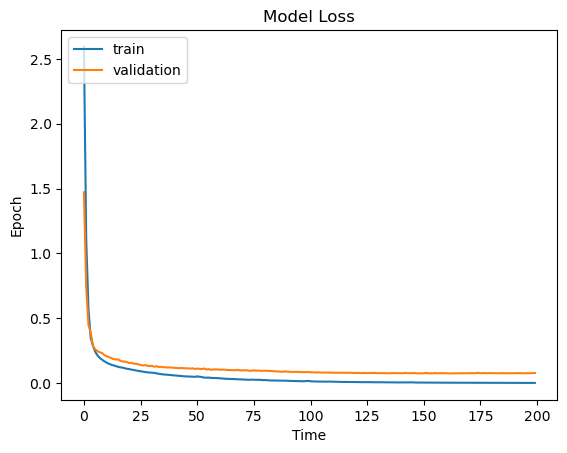

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Time')
plt.ylabel('Epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

In [18]:
_, acc = model_cnn.evaluate(X_test_features, y_test)
print("Test Accuracy : ", acc)

4/4 [==============================] - 0s 3ms/step - loss: 0.0780 - acc: 0.9667
Test Accuracy :  0.9666666388511658


4/4 [==============================] - 0s 2ms/step


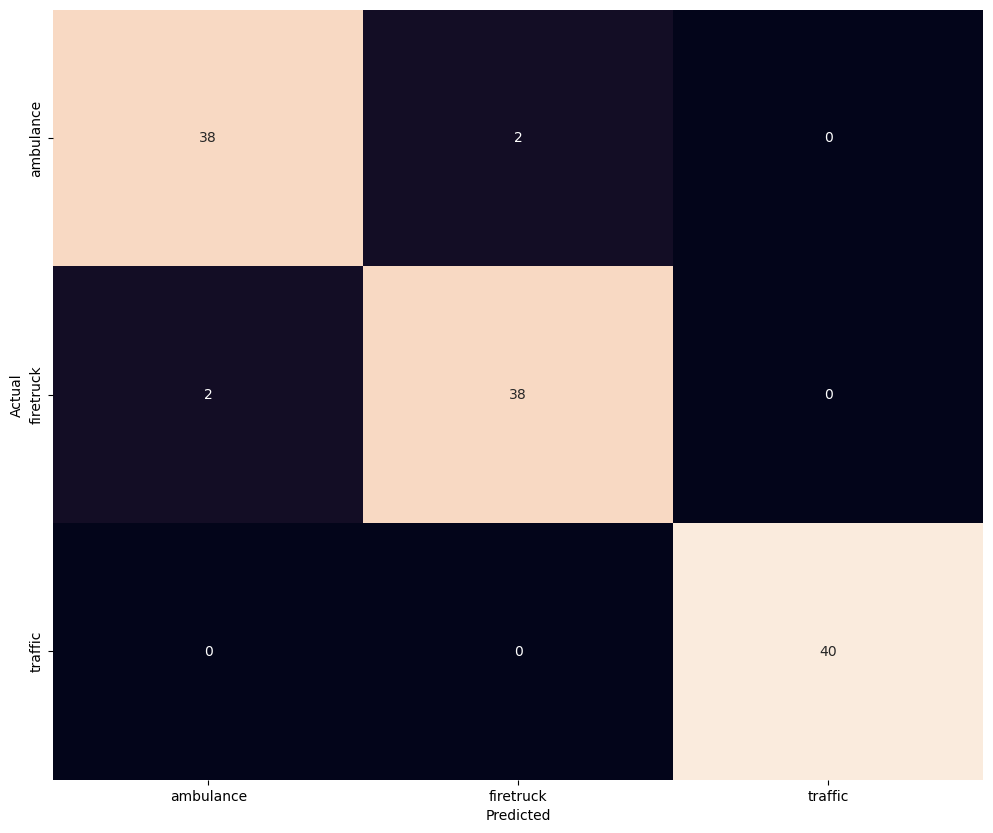

In [19]:
y_pred = model_cnn.predict(X_test_features)

conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [20]:
model_cnn.save('./CNN_Model')

INFO:tensorflow:Assets written to: ./CNN_Model\assets


INFO:tensorflow:Assets written to: ./CNN_Model\assets
